In [1]:
import numpy as np
import scipy.stats as ss
import time
import scipy
import h5py
from scipy.stats import gaussian_kde, wishart, poisson, norm, multivariate_normal
from scipy.special import logsumexp

import dynesty
from dynesty.utils import resample_equal

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn
import corner
import matplotlib.lines as mlines

/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import sys
sys.path.append('./..')

In [3]:
params = {'font.family': 'DejaVu Serif',
          'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'xtick.direction':'in',
          'ytick.direction':'in',
          'ytick.labelsize':'large','font.size':19}
plt.rcParams.update(params)
inches_to_cm = 2.54
figsize = (40/inches_to_cm, 13/inches_to_cm)
dpi = 180

### Define Model

In [4]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.rosen.html
def rosen(x):
    """The Rosenbrock function"""
    if len(x.shape) > 1:
        p = np.sum(100*(x[:,1:] - x[:,:-1]**2)**2 + (1 - x[:,:-1])**2, axis=1)
        return -np.array(p)
    else:
        p = sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)
        return -p

#https://git.ligo.org/gregory.ashton/bilby_mcmc_validation/-/blob/master/Rosenbrock/analyse.py
def draw_rosenbrock(limit=5, n_samples=1000000):
    """
    Draw from a 2D Rosenbrock distribution

    This is done by reparameterizing the problem as

    z = 10 (y - x^2)
    w = x - 1

    so that

    lnL = - (w^2 + z^2)
    """
    z = np.random.normal(0, 2 ** -0.5, n_samples * 2)
    w = np.random.normal(0, 2 ** -0.5, n_samples * 2)

    x = w + 1
    y = z / 10 + x ** 2

    keep = (abs(x) < 5) & (abs(y) < 5)

    x = x[keep][:n_samples]
    y = y[keep][:n_samples]
    return x, y

true = draw_rosenbrock()
true = np.transpose(true)

### Sample Using Varaha

In [5]:
from functions import *

In [6]:
# User provided
ndim = 10
maxx = 5

xrange = np.vstack([[-maxx, maxx]  for ii in range(ndim)]) #Start with a large rectangular bin same as dynesty.
xbox = np.array([[0, 1]] * ndim)#Start with a box.
#Sampler
dx, binunique, nbins, ninbin, lkl_thr, log_V, log_deltaV = {}, {}, {}, {}, {}, {}, {}
allx, allloglkl = np.transpose([[]] * ndim), []
cycle = lkl_cycle = probmass_cycle = 1
dx[cycle] = np.diff(xbox, axis = 1).flatten()
binunique[cycle] = np.array([ndim * [0]]) #There is only one unique bin in the beginning
nbins[cycle] = np.ones(ndim)
allx_log_injd = []
log_V[lkl_cycle] = 0
log_deltaV[lkl_cycle] = -np.inf
lkl_thr[lkl_cycle] = -np.inf
pinside = 1.0
perc_acc = 0.95
ti = 0
sampidx = []
del_upto_lkl = {}
del_upto_lkl[cycle] = -np.inf
nback = int(-np.log(2.0)/np.log(perc_acc))

max_injneff = 10000
nsel = 2000
nmc = int(max_injneff/perc_acc) + 1
# The number of samples in each unique bin. There is only one so all samples go there
ninbin[cycle] = [nmc]
t0 = time.time()

while pinside > 0.05:
    
    x = sample_from_bins(xbox, dx[cycle], binunique[cycle], ninbin[cycle])
    xprior = xrange.T[0] + x * np.diff(xrange).flatten()#map back to original prior
    log_lkl = rosen(xprior)
    ti += x.shape[0]

    idx = np.where(log_lkl >= lkl_thr[probmass_cycle])
    x = x[idx]
    log_lkl = log_lkl[idx]

    if cycle > 1:
        idx = np.where(allloglkl >= lkl_thr[probmass_cycle])
        allx = allx[idx]
        allloglkl = allloglkl[idx]
        allx_log_injd = allx_log_injd[idx]
        sampidx = sampidx[idx]

    allx_log_injd, log_injd_x = \
                update_injection_density(allx, x, allx_log_injd, xbox, dx, binunique, ninbin, cycle, 5)

    allx = np.append(allx, x, axis = 0)
    allloglkl = np.append(allloglkl, log_lkl)
    allx_log_injd = np.append(allx_log_injd, log_injd_x)
    sampidx = np.append(sampidx, cycle * np.ones_like(log_lkl))
    eff = len(log_lkl[log_lkl >= lkl_thr[lkl_cycle]]) / np.sum(ninbin[cycle])

    idx = np.where(allloglkl >= lkl_thr[lkl_cycle])
    log_injw = -allx_log_injd[idx]
    injw = np.exp(log_injw - log_injw.max())
    injneff = injw.sum() ** 2 / (injw**2).sum()

    next_lkl_thr = get_likelihood_threshold(allloglkl[idx], injw, False, perc_acc)
    sum1 = injw.sum()

    if sum1 > nsel and injneff > max_injneff:
        lkl_cycle += 1
        lkl_thr[lkl_cycle] = next_lkl_thr
        log_V[lkl_cycle], log_deltaV[lkl_cycle], _ = \
                volume_at_threshold(injw, allloglkl[idx], next_lkl_thr, log_V[lkl_cycle - 1], -np.inf, True)
        log_deltaV[lkl_cycle] = log_V[lkl_cycle] - 0.5 * np.log(injneff)
    del_upto_lkl[cycle] = lkl_thr[lkl_cycle]
    if probmass_cycle > 5 * nback:
        dx, binunique, ninbin, ninbin, allx_log_injd, allx, allloglkl, sampidx = \
            remove_early_cycles(allx_log_injd,allx,allloglkl,sampidx,xbox,dx,binunique,ninbin,del_upto_lkl, lkl_thr[probmass_cycle - 5 * nback], 5)
            
    lw  = allloglkl - allx_log_injd
    w = np.exp(lw - lw.max())
    neff_varaha = rnd(w.sum() ** 2 / (w**2).sum(), 1)
    nred = w.sum()/w.max()
    pinside = w[allloglkl > lkl_thr[lkl_cycle]].sum() / w.sum()
    if pinside > 0.999:
        probmass_cycle = max(probmass_cycle, lkl_cycle - nback)

    idx = np.where(allloglkl >= lkl_thr[lkl_cycle])
    log_injw = -allx_log_injd[idx]
    injw = np.exp(log_injw - log_injw.max())
    injnef = injw.sum() ** 2 / (injw ** 2).sum()

    nsamp = (1 - perc_acc) * len(injw) / eff / 0.9
    nsamp *= (max_injneff/injnef)

    selx = allx[idx]
    ldeltav = log_deltaV[lkl_cycle]
    frac_err = np.exp(ldeltav - log_V[lkl_cycle])

    cycle += 1
    nbins[cycle], dx[cycle] = \
            get_bins(ldeltav, xbox, ndim, 0, cycle)

    binidx = ((selx - xbox.T[0]) / dx[cycle]).astype(int) #bin indexs of the samples
    binunique[cycle], invidx = np.unique(binidx, return_inverse=True, axis = 0)
    bin_injd = np.zeros(binunique[cycle].shape[0])
    exp = np.exp(allx_log_injd[idx])
    for ii in invidx:
        bin_injd[ii] += exp[ii]        
    ninbin[cycle] =  bin_injd.max() - bin_injd
    if ninbin[cycle].max() == 0:
        ninbin[cycle] = np.ones_like(ninbin[cycle])
    p = ninbin[cycle] * nsamp / ninbin[cycle].sum()
    ninbin[cycle] = p.astype(int)
    p -= ninbin[cycle]
    idx = np.where(p > np.random.random(len(p)))
    ninbin[cycle][idx] += 1
    binunique[cycle] = binunique[cycle][ninbin[cycle] > 0]
    ninbin[cycle] = ninbin[cycle][ninbin[cycle] > 0]
    nmc = np.sum(ninbin[cycle])

    print (len(dx.keys()), probmass_cycle, rnd(sum1, 1), rnd(injneff, 1), rnd(eff, 5))
    print(cycle, lkl_cycle, np.round(pinside,5), allx.shape, selx.shape,binunique[cycle].shape, nbins[cycle])
    print (neff_varaha, nred, rnd(np.max(allloglkl),1),lkl_thr[lkl_cycle],np.exp(log_V[lkl_cycle]),frac_err,nmc,ti)
    print ()
    
    if cycle > 1000:
        break
allx = xrange.T[0] + allx * np.diff(xrange).flatten()#map back to original prior
selx = xrange.T[0] + selx * np.diff(xrange).flatten()#map back to original prior
print ('time taken by Varaha:', np.round(time.time() - t0), 1)

2 1 10527.0 10527.0 1.0
2 2 1.0 (10527, 10) (10001, 10) (105, 10) [3. 1. 1. 2. 3. 1. 2. 1. 3. 1.]
1.0 1.0 -1364.7 -218885.96427517972 0.9499382540134891 0.009746477589434498 553 10527

3 1 10021.0 10513.0 0.93671
3 3 1.0 (11080, 10) (9991, 10) (111, 10) [2. 7. 1. 1. 1. 1. 2. 1. 1. 4.]
1.0 1.0 -1364.7 -195153.3522206885 0.9023783820425022 0.009752946438573678 593 11080

4 1 9542.3 10516.7 0.90388
4 4 1.0 (11673, 10) (9999, 10) (125, 10) [2. 2. 1. 2. 2. 1. 2. 1. 2. 2.]
1.0 1.0 -1364.7 -179684.68803583717 0.8572106516117721 0.009751248569858978 612 11673

5 1 9179.6 10503.9 0.85294
5 5 1.0 (12285, 10) (9992, 10) (123, 10) [3. 1. 2. 7. 1. 3. 1. 1. 1. 1.]
1.0 1.0 -1364.7 -168682.8718965695 0.814329980918853 0.009757207294566464 654 12285

6 1 8823.1 10488.6 0.79205
6 6 1.0 (12939, 10) (9978, 10) (126, 10) [2. 1. 2. 2. 2. 2. 2. 1. 2. 1.]
1.0 1.0 -1364.7 -159411.9495669717 0.7736127791470729 0.00976428975453839 707 12939

7 1 8489.9 10493.9 0.76662
7 7 1.0 (13646, 10) (9989, 10) (134, 10) [3.

In [7]:
#run dynesty
# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -10. and 10. in each variable."""
    return maxx * (2. * u - 1.)

# multivariate slice sampling ('slice') 
t0 = time.time()

sampler = dynesty.NestedSampler(rosen, prior_transform, ndim, nlive = 5000, sample= 'rwalk', walks= 200)
sampler.run_nested(dlogz=0.1)
res = sampler.results

print ('Time taken Dynesty:', np.round(time.time() - t0, 1))

224732it [1:09:37, 53.80it/s, +5000 | bound: 285 | nc: 1 | ncall: 41565235 | eff(%):  0.553 | loglstar:   -inf < -0.324 <    inf | logz: -42.983 +/-  0.089 | dlogz:  0.000 >  0.100]


Time taken Dynesty: 4178.9


In [8]:
dweights = np.exp(res['logwt'] - res['logz'][-1])
dpostsamples = resample_equal(res.samples, dweights)
ns_idx = np.where(np.cumsum(dweights)/dweights.max() > 0.0000001)
print (dweights.sum() ** 2 / (dweights ** 2).sum()/sampler.ncall, neff_varaha/ti)

0.0011935419865359302 0.014055864923876775


In [9]:
log_injw = -allx_log_injd
injw = np.exp(log_injw - log_injw.max())

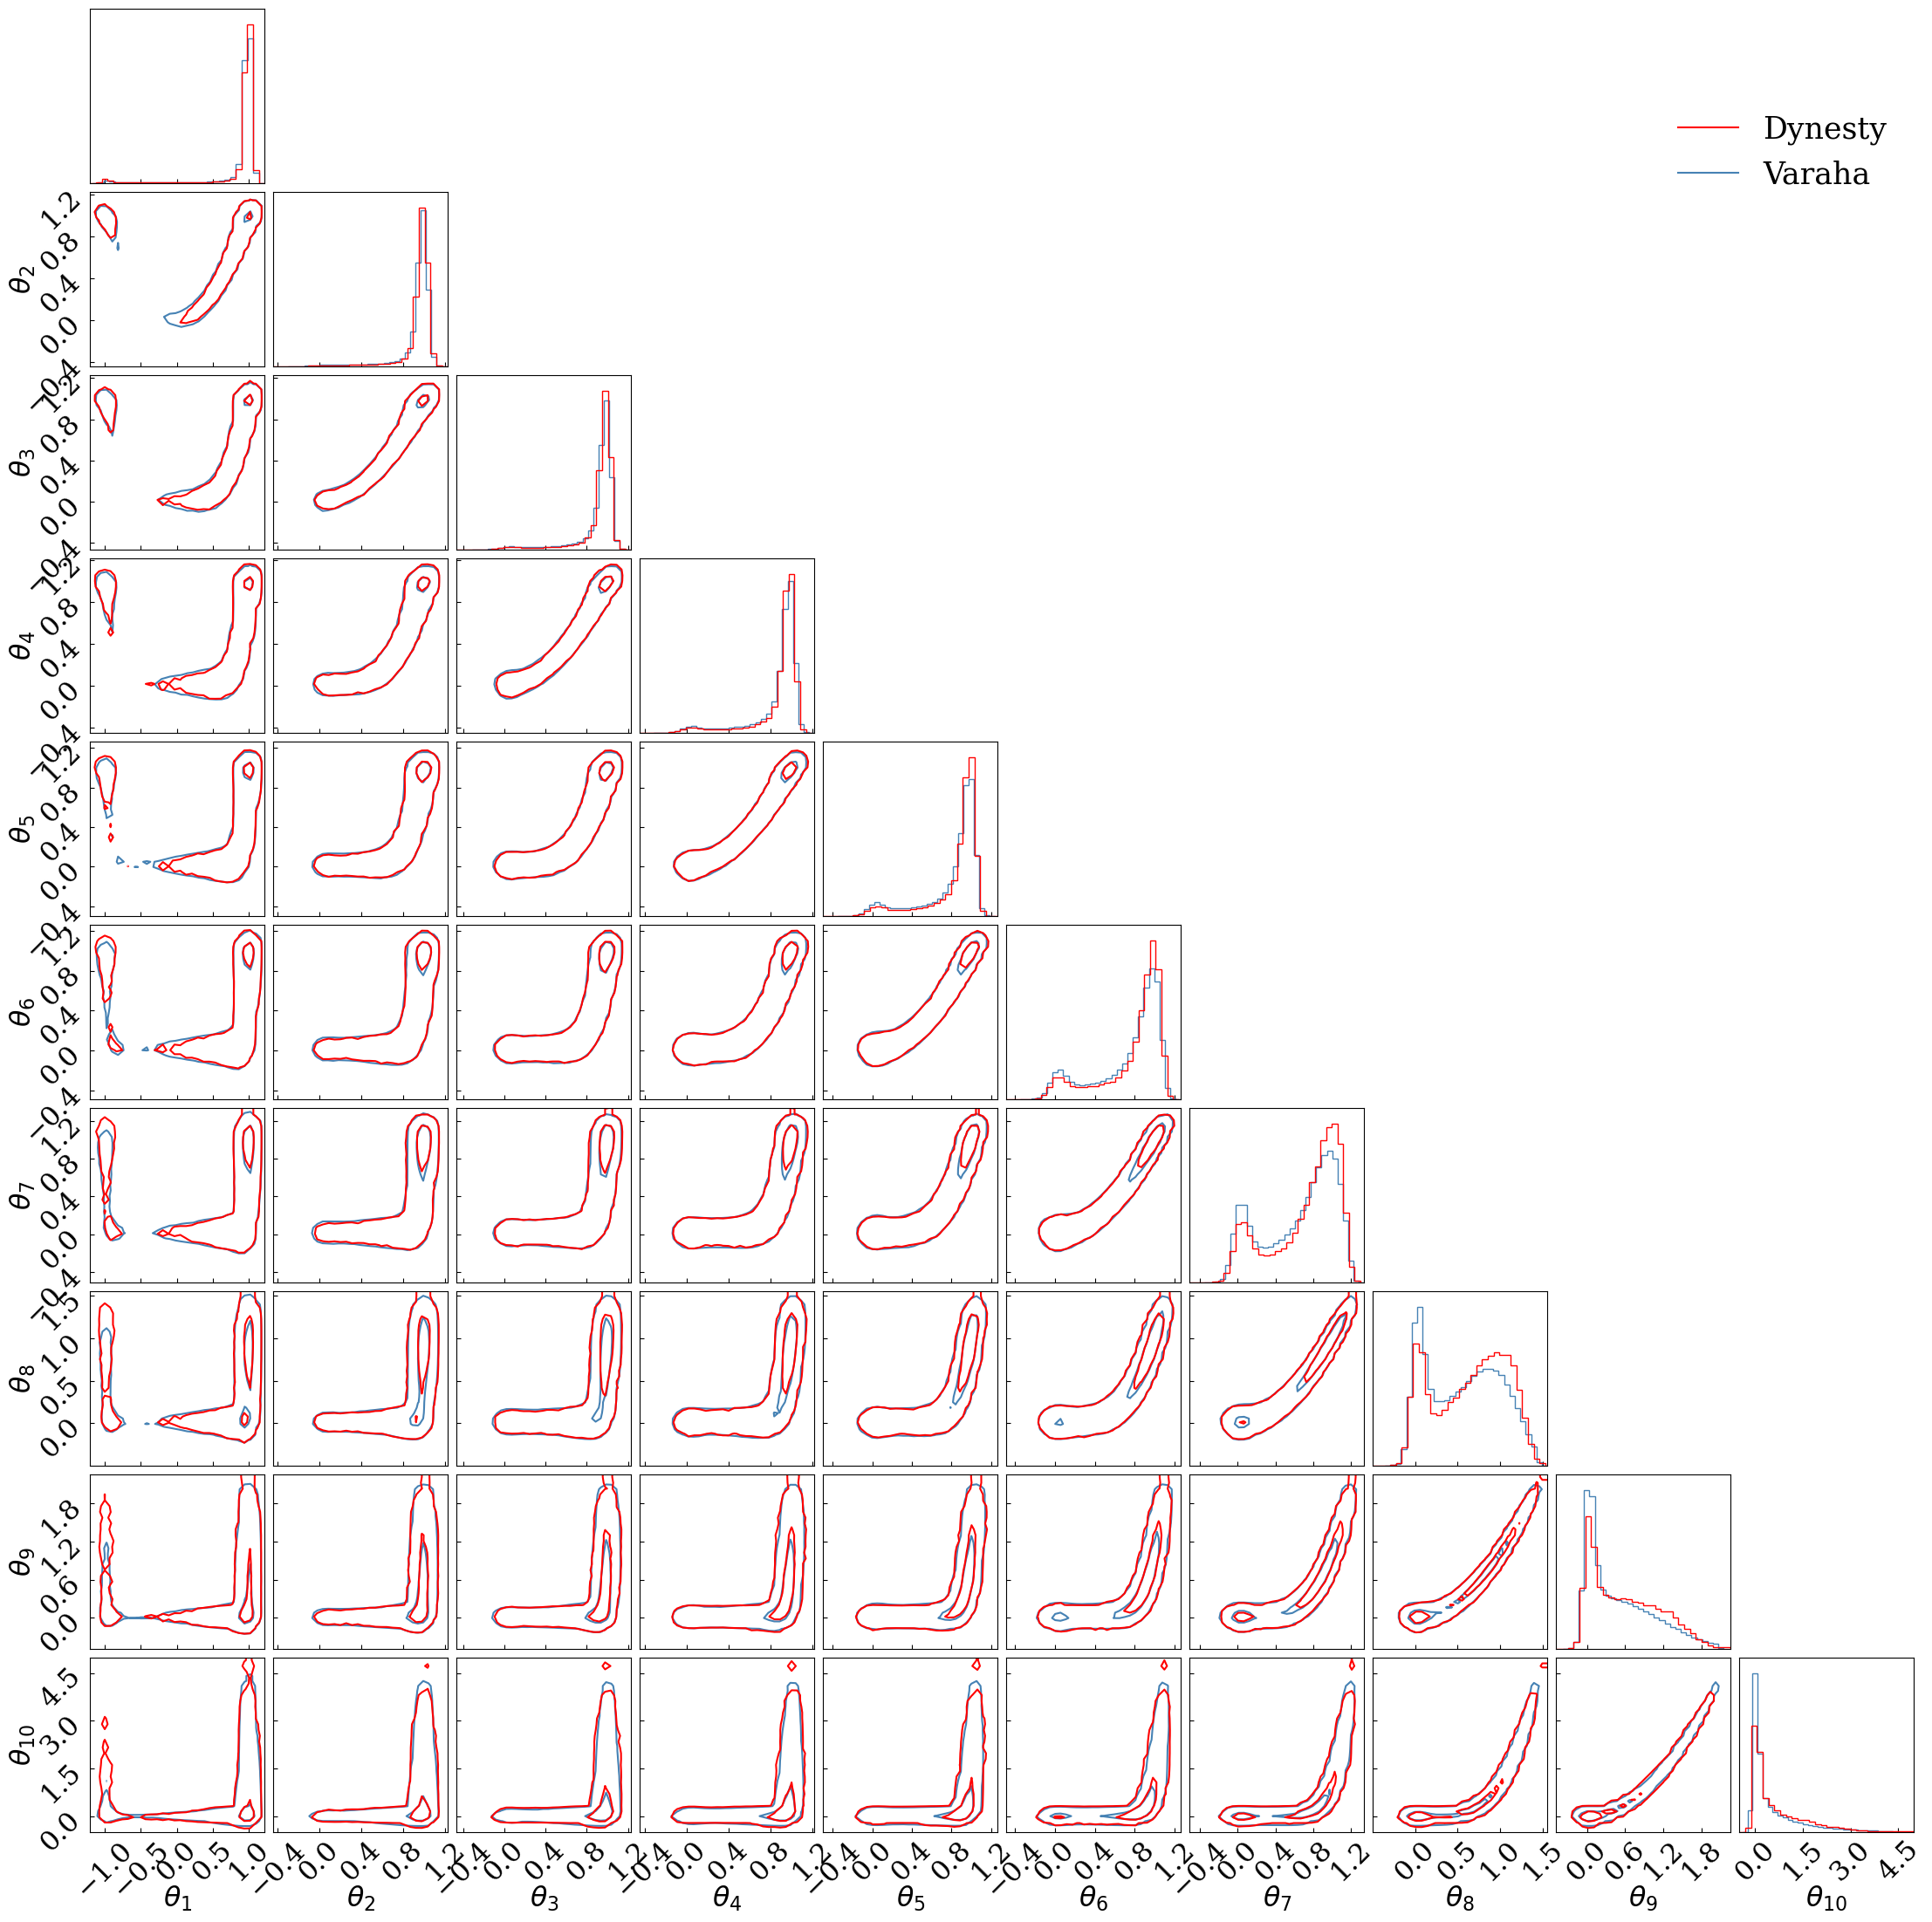

In [10]:
idx = np.where(w > 0.0000001)

l=[]
for ii in range(ndim):
    l.append(r'$\theta_{' + str(ii+1) + '}$')
hh = dict(density=True, color = 'steelblue')

figure = corner.corner(allx[idx], color='steelblue', bins = 30, levels=(0.5, 0.99), 
              plot_density=False, plot_datapoints=False, weights=w[idx], hist_kwargs=hh, max_n_ticks=3)
hh = dict(density=True, color = 'red')
corner.corner(res.samples[ns_idx], weights=dweights[ns_idx], fig=figure, color='red', bins = 30, levels=(0.5, 
            0.99), plot_density=False, plot_datapoints=False, hist_kwargs=hh, density=True, labels=l)

plt.legend(handles=[mlines.Line2D([], [], color='red', label='Dynesty'), mlines.Line2D([], [], color='steelblue', 
    label='Varaha')], fontsize=25, frameon=False, bbox_to_anchor=(1, ndim), loc="upper right")
plt.savefig('files/rosenbrock.jpg', dpi = 200., bbox_inches  = 'tight')